In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


<h1 style="text-align:center; color:#000080; font-weight:bold; font-size:38px;">Customer Segmentation</h1>

# Dataset Description: Online Retail Data

This dataset contains transactional data of an **online retail store** based in the UK. It includes information about orders placed by customers between **December 2010** and **December 2011**.

## Features
- **InvoiceNo**: A unique number assigned to each transaction. Prefix 'C' indicates a canceled transaction.
- **StockCode**: A unique identifier for each product (item) in the inventory.
- **Description**: A brief description of the product.
- **Quantity**: The number of items purchased per transaction. Negative values indicate product returns.
- **InvoiceDate**: The date and time when the transaction was recorded.
- **UnitPrice**: The price of a single product per unit (in GBP).
- **CustomerID**: A unique identifier for each customer. Missing values represent unidentified customers.
- **Country**: The country where the customer resides.

## Key Insights
- The dataset primarily represents transactions from **UK-based customers**, but it also includes transactions from other countries.
- It contains **missing values** in the `CustomerID` column, which may require preprocessing.
- Negative quantities in the `Quantity` column indicate **returns or canceled orders**.
- This dataset is ideal for **RFM analysis** to segment customers based on their purchasing behavior.

## Size and Format
- Number of Rows: **541,909**
- Number of Columns: **8**
- File Format: **CSV**


<h1 style="text-align:left; color:#FF5733; font-weight:bold; font-size:28px; font-family:Arial, sans-serif;">Import Libraries</h1>

In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

<h1 style="text-align:left; color:#FF5733; font-weight:bold; font-size:28px; font-family:Arial, sans-serif;">Remove Warnings</h1>


In [3]:
import warnings
warnings.filterwarnings('ignore')

<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#20B2AA; overflow:hidden"><b>Reading The Data</b></div>

In [4]:
df = pd.read_csv("/kaggle/input/ecommerce-data/data.csv", encoding='ISO-8859-1')

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
df.shape

(541909, 8)

- **Number of Instances**: 541,909
- **Number of Attributes**: 8
- **Missing Values**: The dataset contains missing values, particularly in the CustomerID and Description columns.

<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#20B2AA; overflow:hidden"><b>Data Preprocessing</b></div>

## 1.Null Values

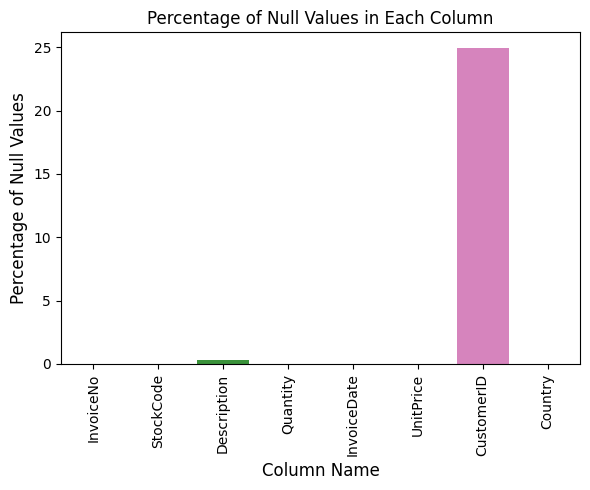

In [8]:
null_percentages = (df.isnull().sum()/df.shape[0])*100
null_percentages = null_percentages.reset_index()
null_percentages.columns = ['Column Name','Percentage']
plt.figure(figsize=(6,5))
sns.barplot(data=null_percentages,x='Column Name',y='Percentage')
plt.xlabel('Column Name',fontsize = 12)
plt.ylabel('Percentage of Null Values',fontsize = 12)
plt.title('Percentage of Null Values in Each Column')
plt.xticks(rotation=90,fontsize = 10)
plt.tight_layout()
plt.show()

 - The **CustomerID** column contains nearly a quarter of missing values, which poses a
 challenge for customer segmentation. Since this column is crucial for uniquely
 identifying customers and linking their purchasing patterns, handling these missing
 values carefully is essential. 

## 2.Duplicated Values

In [9]:
df.dropna(subset=['CustomerID'], inplace=True)
print(f"Null Values in the Dataset {((df.isnull().sum()/df.shape[0])*100).sum()}")

Null Values in the Dataset 0.0


In [10]:
print(f"Duplicated Values in the Dataset {df.duplicated().sum()}")
print(f"Percentage of Duplicates {np.round((df.duplicated().sum()/df.shape[0])*100, 2)}")
print("*"* 45)
df[df.duplicated(keep=False)].sort_values(by='InvoiceNo')

Duplicated Values in the Dataset 5225
Percentage of Duplicates 1.28
*********************************************


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
440149,C574510,22360,GLASS JAR ENGLISH CONFECTIONERY,-1,11/4/2011 13:25,2.95,15110.0,United Kingdom
461407,C575940,23309,SET OF 60 I LOVE LONDON CAKE CASES,-24,11/13/2011 11:38,0.55,17838.0,United Kingdom
461408,C575940,23309,SET OF 60 I LOVE LONDON CAKE CASES,-24,11/13/2011 11:38,0.55,17838.0,United Kingdom
529981,C580764,22667,RECIPE BOX RETROSPOT,-12,12/6/2011 10:38,2.95,14562.0,United Kingdom


 The dataset contains **5,225** duplicate entries, accounting for **1.28%** of the total data.
 These duplicates will be removed to ensure the integrity and accuracy of the analysis

In [11]:
df.drop_duplicates(inplace=True)
print(f"Duplicated Values in the Dataset {df.duplicated().sum()}")
print(f"Percentage of Duplicates {np.round((df.duplicated().sum()/df.shape[0])*100, 2)}")

Duplicated Values in the Dataset 0
Percentage of Duplicates 0.0


## 3.Cancelled Transactions

In [12]:
canceled_orders = df[df['InvoiceNo'].str.startswith('C')]
print(f"Total Canceled Orders {canceled_orders.shape[0]}")
print(f"Percentage of Canceled Orders {np.round((canceled_orders.shape[0]/df.shape[0])*100,2)}")
print()
print("*"*45)
canceled_orders.head()

Total Canceled Orders 8872
Percentage of Canceled Orders 2.21

*********************************************


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


 The **8,872** canceled orders, representing **2.21%** of the dataset, have been removed to
 ensure the analysis focuses on completed transactions and yields accurate insights.

In [13]:
print(f"Shape of the Dataset Before Cleaning cancel orders {df.shape}")
df = df[~df['InvoiceNo'].str.startswith('C')]
print(f"Shape of the Dataset After Cleaning cancel orders {df.shape}")

Shape of the Dataset Before Cleaning cancel orders (401604, 8)
Shape of the Dataset After Cleaning cancel orders (392732, 8)


In [14]:
# To check if there are any rows in the DataFrame where 'InvoiceNo' contains alphabetic characters (e.g., for identifying special invoices like canceled ones).
df[df['InvoiceNo'].str.contains('[a-zA-Z]',regex=True)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


## 4.StockCode Anomalies

In [15]:
anomaly_stock_codes = df[df['StockCode'].str.contains('^[a-zA-Z]',regex=True)]['StockCode']
print(f"Number of Anomaly Stock Codes : {anomaly_stock_codes.nunique()} \n")
for stock_code in anomaly_stock_codes.unique():
    desc = df[df['StockCode'] == stock_code]
    print(f"{stock_code} ---> {desc['Description'].iloc[0]}")
print(f"\nTotal Number of Orders with Anomaly Stock Codes : {anomaly_stock_codes.shape[0]}")

Number of Anomaly Stock Codes : 6 

POST ---> POSTAGE
C2 ---> CARRIAGE
M ---> Manual
BANK CHARGES ---> Bank Charges
PADS ---> PADS TO MATCH ALL CUSHIONS
DOT ---> DOTCOM POSTAGE

Total Number of Orders with Anomaly Stock Codes : 1549


In [16]:
print(f"Shape of the Dataset Before removing Anomaly Stock Codes {df.shape}")
df = df[~df['StockCode'].str.contains('^[a-zA-Z]',regex=True)]
print(f"Shape of the Dataset After removing Anomaly Stock Codes {df.shape}")

Shape of the Dataset Before removing Anomaly Stock Codes (392732, 8)
Shape of the Dataset After removing Anomaly Stock Codes (391183, 8)


## 5.Description Anomalies

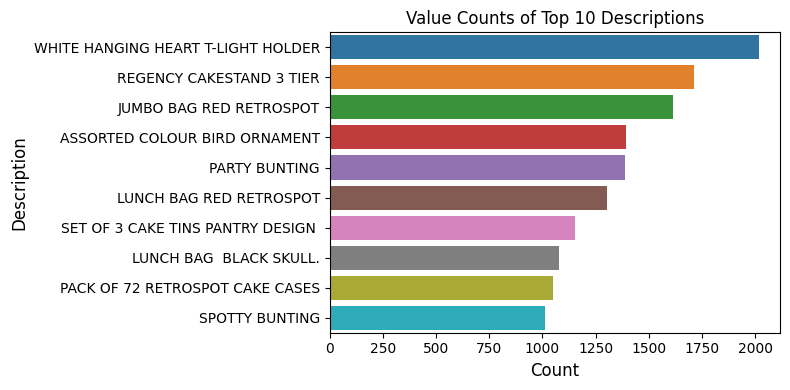

In [17]:
description = df['Description'].value_counts()[:10].reset_index()
description.columns = ['Description','Count']
plt.figure(figsize=(8,4))
sns.barplot(data=description,x='Count',y='Description')
plt.xlabel('Count',fontsize = 12)
plt.ylabel('Description',fontsize = 12)
plt.title('Value Counts of Top 10 Descriptions')
plt.tight_layout()
plt.show()

### Observations from the Bar Graph

From the bar graph, we can observe that product descriptions are typically entered in **uppercase**. Any entries in **lowercase** may represent anomalies or errors. Therefore, it is essential to:

- Check for such entries
- Handle them appropriately to maintain consistency in the dataset

In [18]:
anomaly_desc = df[df['Description'].str.contains('[a-z]',regex=True)]['Description']
for desc in anomaly_desc.unique():
  print(desc)

BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
NUMBER TILE COTTAGE GARDEN No
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


 The descriptions **Next Day Carriage** and **High Resolution Image** are identified as
 anomalies. Calculating the number of records with these descriptions is necessary,
 followed by appropriate handling to ensure data consistency and accuracy in the
 analysis

In [19]:
df[(df['Description'] == 'Next Day Carriage') | (df['Description'] == 'High Resolution Image')].shape[0]

82

In [20]:
df = df[~((df['Description'] == 'Next Day Carriage') | (df['Description'] == 'High Resolution Image'))]

There are only **82 records** with the anomalies "Next Day Carriage" and "High Resolution
Image". These records have been removed to maintain the quality and consistency of the
dataset.

In [21]:
df[['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,391101.000000,391101.000000
mean,13.182216,2.871599
std,181.926386,4.281346
min,1.000000,0.000000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,649.500000


In [22]:
df = df[df['UnitPrice']>0]

The dataset contains records with a UnitPrice of 0, which is invalid. Therefore, only
records with a UnitPrice greater than zero have been retained. Additionally, upon
examining the descriptive statistics, it is evident that there are outliers in the data that need to be addressed.

In [23]:
df["TotalPrice"] = df["Quantity"]*df["UnitPrice"]

<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#20B2AA; overflow:hidden"><b>RFM Analysis</b></div>

### RFM (Recency, Frequency, Monetary) Analysis

RFM analysis is a **customer segmentation technique** used to help businesses understand customer behavior and categorize them into different groups based on their purchasing patterns. It is widely used in marketing and customer relationship management to target specific customer segments effectively.

This technique involves **quantitatively ranking** and grouping customers based on the **recency**, **frequency**, and **monetary** total of their recent transactions. The system assigns each customer numerical scores based on these factors to provide an objective analysis, helping businesses identify the best customers and perform targeted marketing campaigns.

RFM analysis is based on the marketing adage that **"80% of your business comes from 20% of your customers."**

#### 1. **Recency (R)**
- **Definition**: How recently a customer made a purchase.
- Customers who purchased recently are more likely to respond to promotions.
- **Example**: A customer who bought something last week is more valuable than one who bought a year ago.

#### 2. **Frequency (F)**
- **Definition**: How often a customer makes purchases.
- Frequent buyers are more engaged and loyal to the business.
- **Example**: A customer who makes frequent purchases is more valuable than one who buys once a year.

#### 3. **Monetary (M)**
- **Definition**: How much money a customer spends.
- Customers who spend more are more valuable.
- **Example**: A customer who has spent **\$5,000** in total is more valuable than one who has spent **\$1,000**.

### How It Works
1. **Data Collection**:  
   - Last purchase date (Recency)  
   - Transaction count (Frequency)  
   - Total spend (Monetary)  

2. **Scoring**:  
   - Customers ranked in quintiles (1-5) for each metric  
   ```python
   df['R_Score'] = pd.qcut(df['Recency'], 5, labels=[5,4,3,2,1])
   df['F_Score'] = pd.qcut(df['Frequency'], 5, labels=[1,2,3,4,5])
   df['M_Score'] = pd.qcut(df['Monetary'], 5, labels=[1,2,3,4,5])   

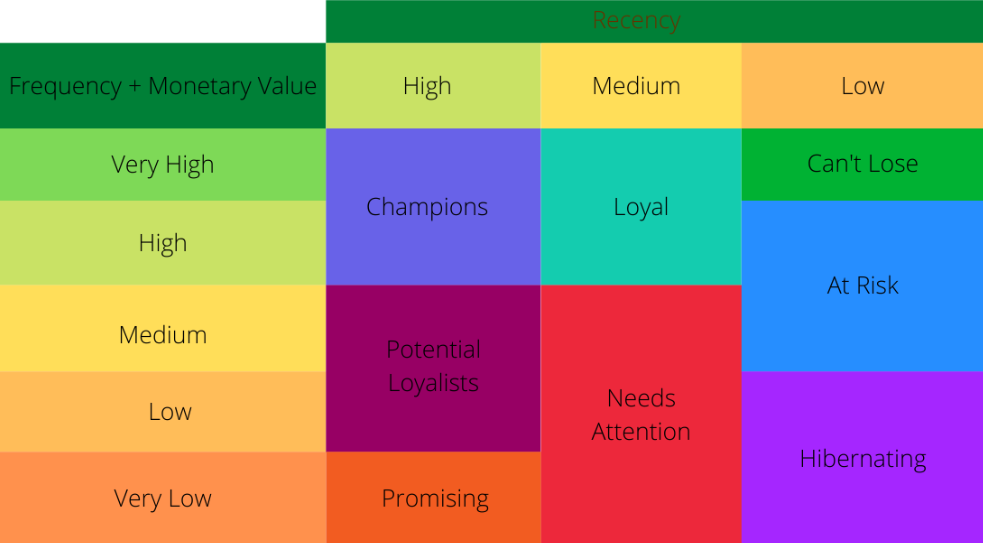

## Recency

In [24]:
df["Date"] = pd.to_datetime(df["InvoiceDate"]) 
reference_date = max(df["Date"]) + pd.DateOffset(days=1) 
recency = (reference_date - df.groupby('CustomerID')["Date"].max()).dt.days 
recency.name = "Recency"
recency.head(2)

CustomerID
12346.0    326
12347.0      2
Name: Recency, dtype: int64

## Frequency

In [25]:
freq = df.groupby('CustomerID')['Date'].count()
freq.name = "Freq"
freq.head(2)

CustomerID
12346.0      1
12347.0    182
Name: Freq, dtype: int64

## Monetary

In [26]:
monetary = df.groupby('CustomerID')['TotalPrice'].sum()
monetary.name = "Monetary"
monetary.head(2)

CustomerID
12346.0    77183.6
12347.0     4310.0
Name: Monetary, dtype: float64

In [27]:
recency_df = recency.reset_index()
recency_df.columns = ['CustomerID', 'Recency']
frequency_df = freq.reset_index()

In [28]:
frequency_df.columns = ['CustomerID', 'Frequency']
monetary_df = monetary.reset_index()
monetary_df.columns = ['CustomerID', 'Monetary']
rfm = recency_df.merge(frequency_df, on="CustomerID").merge(monetary_df, on="CustomerID")

In [29]:
rfm = rfm.set_index('CustomerID')

In [30]:
rfm.describe()

,Recency,Frequency,Monetary
count,4334.000000,4334.000000,4334.000000
mean,92.703046,90.232580,2015.690042
std,100.177047,224.707914,8903.655720
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,304.240000
50%,51.000000,41.000000,661.420000
75%,143.000000,98.000000,1631.622500
max,374.000000,7667.000000,279138.020000


From `rfm.describe()`, we notice some extreme values (outliers) in the dataset. These
outliers can affect our analysis, so we need to identify and handle them using methods
like visualization (boxplots) or statistical techniques (IQR, Z-score) for accurate
segmentation.

In [31]:
 def plot_boxplot(data):
  fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,4))
  for idx,feature in enumerate(data.columns):
    sns.boxplot(data=data,x=feature,ax=axes[idx], palette="Blues")
    axes[idx].set_xlabel(f'{feature}',fontsize = 10)
    axes[idx].set_title(f'Box Plot of {feature}')
  plt.tight_layout()
  plt.show()

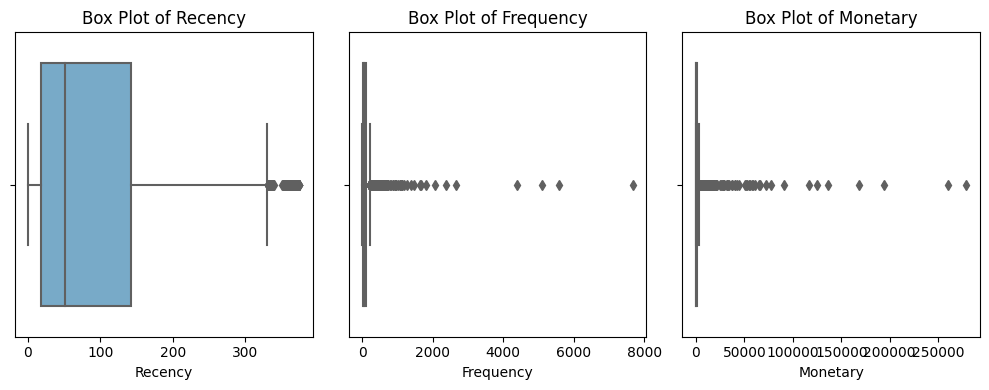

In [32]:
plot_boxplot(rfm)

### Observations from Boxplots

From the boxplots, we observe the following:

- **Recency** has a few outliers, indicating that most of the data points are concentrated within a small range, but there are some values that deviate significantly.
- **Frequency** and **Monetary** show many outliers, suggesting a wider spread of values and potentially a diverse set of customer behaviors.

To gain a deeper understanding of their distributions, we will perform further analysis using **Kernel Density Estimation (KDE) plots**.

In [33]:
def plot_distribution(data):
    fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,4))
    for idx,feature in enumerate(data.columns):
        sns.histplot(data=data,x=feature, palette="Blues",ax=axes[idx],kde=True)
        axes[idx].set_xlabel(f'{feature}',fontsize = 10)
        axes[idx].set_title(f'Box Plot of {feature}')
    plt.tight_layout()
    plt.show()

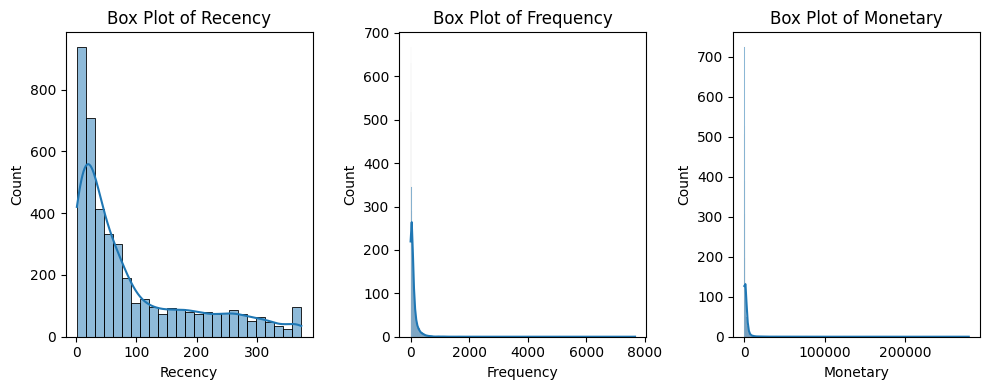

In [34]:
plot_distribution(rfm)

### Skewness in RFM Variables

The **Recency**, **Frequency**, and **Monetary** variables are right-skewed, meaning that the majority of the values are concentrated on the lower end, with a few higher values creating a long tail. 

To address this skewness and reduce the impact of outliers, applying a **log-normal transformation** can help. This transformation can make the distribution more balanced and improve the modeling process by stabilizing variance and making patterns more consistent.


In [35]:

rfm['Recency'] = np.log1p(rfm['Recency'])
rfm['Frequency'] = np.log1p(rfm['Frequency'])
rfm['Monetary'] = np.log1p(rfm['Monetary'])

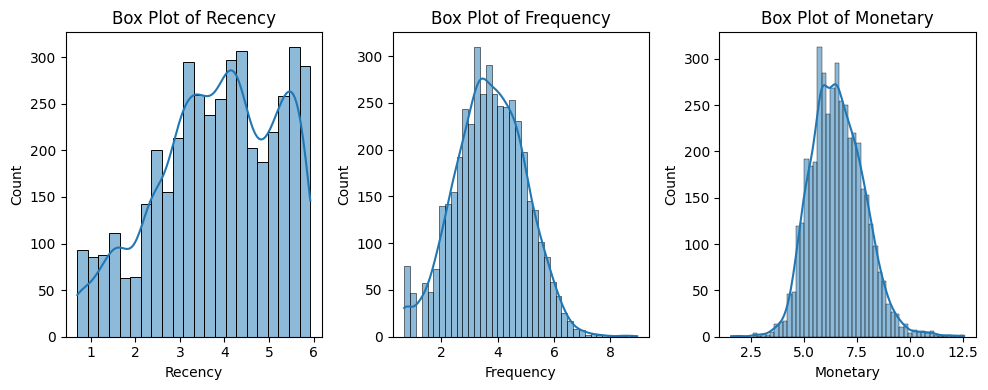

In [36]:
plot_distribution(rfm)

### Effect of Log Transformation

After applying the **log transformation**, we observe the following improvements:

- Both **Frequency** and **Monetary** now follow a **normal distribution**, which indicates that the data is more evenly spread and less affected by outliers.
- This transformation has made the data more balanced, which is important for many statistical and machine learning models that assume normally distributed data.

This adjustment improves the suitability of the data for further analysis and modeling.

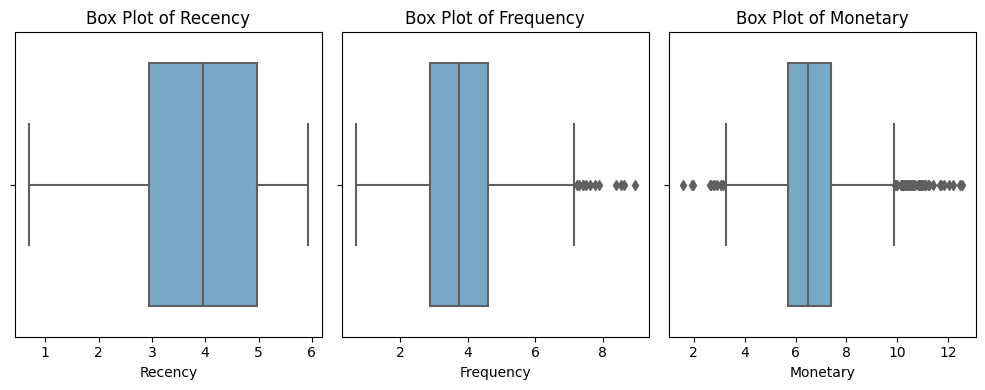

In [37]:
 plot_boxplot(rfm)

### Post-Log Transformation Analysis

From the boxplots, we observe that after applying the **log transformation**, **Frequency** and **Monetary** still have a few outliers. While these outliers are less pronounced compared to the original data, they can still impact the accuracy of segmentation.

To handle these remaining outliers effectively, we can use the **Interquartile Range (IQR)** method. This technique will help in identifying and removing outliers, ensuring better accuracy in customer segmentation and overall analysis.


In [38]:
rfm.describe()

,Recency,Frequency,Monetary
count,4334.000000,4334.000000,4334.000000
mean,3.832072,3.724842,6.575070
std,1.340772,1.246148,1.255304
min,0.693147,0.693147,1.558145
25%,2.944439,2.890372,5.721098
50%,3.951244,3.737670,6.495900
75%,4.969813,4.595120,7.397943
max,5.926926,8.944811,12.539465


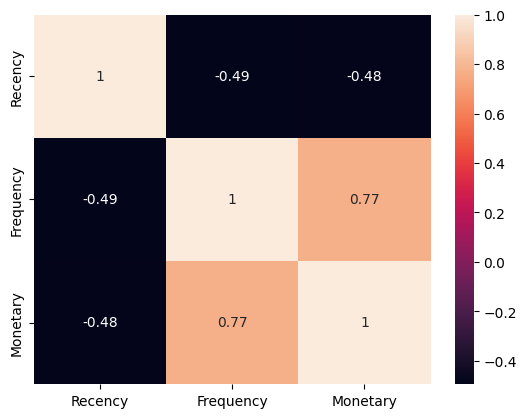

In [39]:
sns.heatmap(rfm.corr(),annot=True)
plt.show()

### Correlation Analysis

From the **correlation analysis**, we observe the following relationships:

- **Recency** has a **negative correlation** with both **Frequency** and **Monetary**. This is logical, as customers who make purchases more frequently tend to have lower recency values (i.e., they made their last purchase more recently).
  
- **Frequency** and **Monetary** show a **positive correlation**, indicating that customers who purchase frequently also tend to spend more. This suggests that frequent buyers are more engaged and contribute more to the overall revenue.

These insights help in understanding customer behavior and can guide marketing strategies for different segments.


## Outliers

In [40]:
def IQR_outlier(data,col):
 Q1 = data[col].quantile(0.25)
 Q3 = data[col].quantile(0.75)
 IQR = Q3 - Q1
 lower_bound = Q1 - 1.5*IQR
 upper_bound = Q3 + 1.5*IQR
 outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
 print(f"Number of Outliers in {col} : {outliers.shape[0]}")
 return lower_bound,upper_bound

In [41]:
lower_bound,upper_bound = IQR_outlier(rfm,'Frequency')
rfm = rfm[(rfm['Frequency'] > lower_bound) &(rfm['Frequency'] < upper_bound)]

Number of Outliers in Frequency : 12


In [42]:
lower_bound,upper_bound = IQR_outlier(rfm,'Monetary')
rfm = rfm[(rfm['Monetary'] > lower_bound) &(rfm['Monetary'] < upper_bound)]

Number of Outliers in Monetary : 44


In [43]:
rfm.describe()

,Recency,Frequency,Monetary
count,4278.000000,4278.000000,4278.000000
mean,3.849925,3.710535,6.541597
std,1.327380,1.212116,1.168768
min,0.693147,0.693147,3.277145
25%,2.944439,2.890372,5.719639
50%,3.960768,3.713572,6.487684
75%,4.976734,4.584967,7.367336
max,5.926926,7.141245,9.839104


## RFM Scoring

In [44]:
rfm["recency_score"] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])


rfm["frequency_score"] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])


rfm["monetary_score"] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])


rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))

In [45]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.reset_index(inplace=True)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12347.0,1.098612,5.209486,8.368925,5,5,5,55,champions
1,12348.0,4.330733,3.332205,7.271175,2,2,4,22,hibernating
2,12349.0,2.995732,4.290459,7.285198,4,4,4,44,loyal_customers
3,12350.0,5.739793,2.833213,5.688330,1,2,2,12,hibernating
4,12352.0,3.610918,4.356709,7.234711,3,4,4,34,loyal_customers


In [46]:
segments_count = rfm.groupby("segment").agg({"CustomerID": "count"})
segments_count.reset_index(inplace=True)
segments_count.columns = ['segment', 'count']
segments_count.head(15)

,segment,count
0,about_to_sleep,316
1,at_Risk,578
2,cant_loose,83
3,champions,616
4,hibernating,1034
5,loyal_customers,786
6,need_attention,200
7,new_customers,63
8,potential_loyalists,504
9,promising,98


In [47]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.reset_index(inplace=True)
rfm.head()

,index,CustomerID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,0,12347.0,1.098612,5.209486,8.368925,5,5,5,55,champions
1,1,12348.0,4.330733,3.332205,7.271175,2,2,4,22,hibernating
2,2,12349.0,2.995732,4.290459,7.285198,4,4,4,44,loyal_customers
3,3,12350.0,5.739793,2.833213,5.688330,1,2,2,12,hibernating
4,4,12352.0,3.610918,4.356709,7.234711,3,4,4,34,loyal_customers


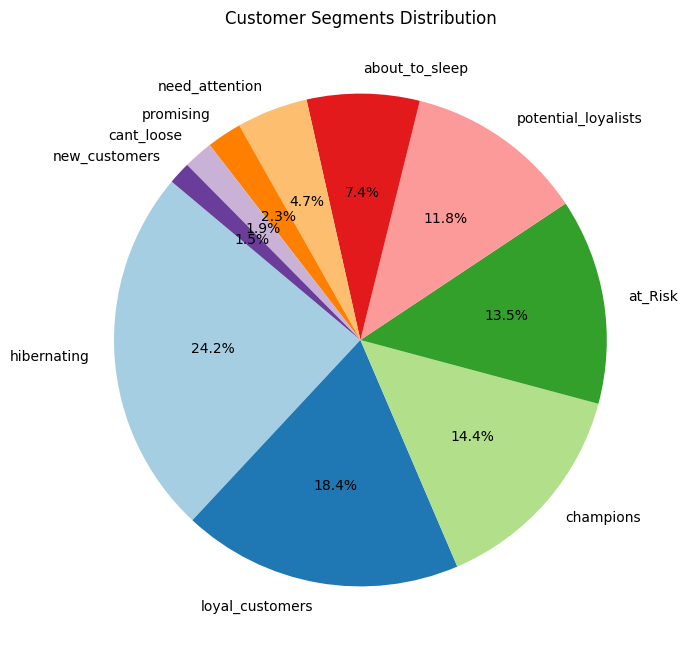

In [48]:
segment_counts = rfm['segment'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Customer Segments Distribution')
plt.show()

### Insights on Champions Segment

Approximately **14.4%** of customers are classified as **Champions**. These customers contribute significantly to your revenue and should be prioritized in your customer retention strategy. To enhance their experience and maintain their loyalty, consider the following actions:

1. **Exclusive Rewards**:
   - Provide them with something extra that regular customers do not get, such as limited edition products or special discounts. This makes them feel valued and appreciated.

2. **Engage as Ambassadors**:
   - Treat them as brand ambassadors by offering incentives for bringing in new customers, such as sharing a margin of your profits or providing referral bonuses.

3. **Request Feedback**:
   - Seek their feedback on your products and services, as they are likely to have deep insights due to their frequent interactions. Their input can help improve your offerings and enhance overall customer satisfaction.

These strategies can help nurture the relationship with Champions and ensure their continued loyalty.


<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#20B2AA; overflow:hidden"><b>Clustering</b></div>

In [49]:
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(rfm.iloc[:,2:5])

In [50]:
df_scaled = pd.DataFrame(df_scaled, columns=['Recency', 'Frequency', 'Monetary'])

df_scaled.head()

,Recency,Frequency,Monetary
0,-2.072981,1.236785,1.563647
1,0.362266,-0.312161,0.624301
2,-0.643593,0.478495,0.636300
3,1.423924,-0.723879,-0.730142
4,-0.180080,0.533158,0.593098


In [51]:
df_scaled["CustomerID"] = rfm['CustomerID']
df_scaled = df_scaled.set_index("CustomerID")

`To determine the optimal number of clusters, I will use the elbow method.`

In [52]:
inertia = []
score = []
for i in range(2,15):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    score.append(silhouette_score(df_scaled,kmeans.labels_))

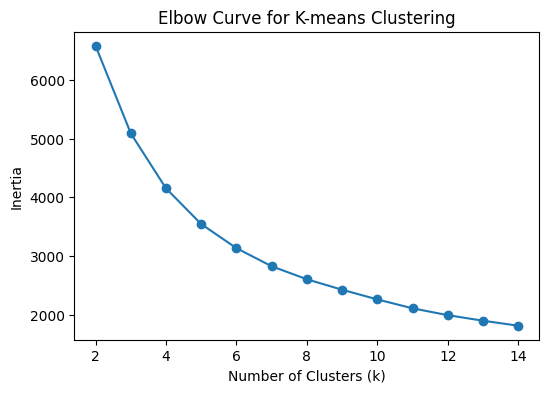

In [53]:
plt.figure(figsize=(6, 4))
plt.plot(range(2, 15), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.show()

### Determining the Optimal Number of Clusters

- From the **elbow curve**, we observe that the **inertia** (sum of squared distances to the nearest cluster center) starts to significantly dip at the **4th cluster**. This suggests that 4 clusters might be the optimal choice.

- To further validate this, we use the **silhouette score**, which measures how well data points fit within their clusters. A **higher silhouette score** indicates better-defined clusters.

Both these methods together provide a robust approach for identifying the ideal number of clusters for segmentation.


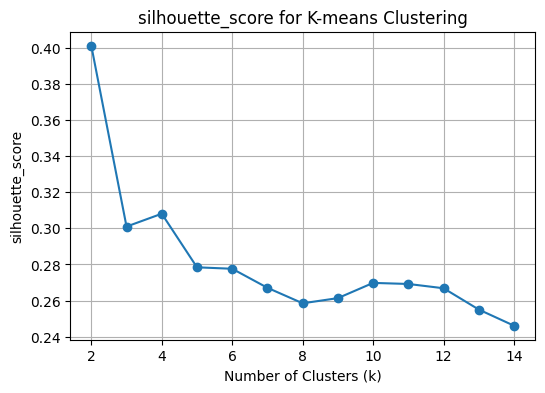

In [54]:
plt.figure(figsize=(6, 4))
plt.plot(range(2, 15), score, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('silhouette_score')
plt.title('silhouette_score for K-means Clustering')
plt.grid(True)
plt.show()

### Silhouette Score Analysis

From the **silhouette score**, we observe that the **4th cluster** achieves the **highest score**, indicating that it has the most well-defined clusters. This makes the 4th cluster the **optimal choice for segmentation**.

The silhouette score helps assess the cohesion and separation of the clusters, ensuring that the data points within a cluster are similar while being distinct from points in other clusters.


In [55]:
kmeans = KMeans(n_clusters=4, random_state=14)
kmeans.fit(df_scaled)
rfm1 = pd.DataFrame()
rfm1 = rfm.loc[:,["Recency","Frequency","Monetary"]]
rfm1['Cluster'] = kmeans.labels_

In [56]:
rfm1.head()

,Recency,Frequency,Monetary,Cluster
0,1.098612,5.209486,8.368925,1
1,4.330733,3.332205,7.271175,2
2,2.995732,4.290459,7.285198,1
3,5.739793,2.833213,5.688330,0
4,3.610918,4.356709,7.234711,2


In [57]:
avg_clusters = rfm1.groupby('Cluster').mean()
avg_clusters = avg_clusters.reset_index()
avg_clusters

,Cluster,Recency,Frequency,Monetary
0,0,5.019757,2.496573,5.415875
1,1,2.402865,5.188315,8.015080
2,2,4.424899,4.128353,6.951638
3,3,2.813437,3.431076,6.141770


### Cluster Naming with Defined Labels

| Cluster | Name               | Rationale                                                                 |
|---------|--------------------|---------------------------------------------------------------------------|
| **0**   | **At Risk**        | Highest recency (5.02) indicates inactivity. Moderate frequency (2.50) and monetary (5.42) suggest declining engagement. |
| **1**   | **Champions**      | Exceptional frequency (5.19) and monetary (8.02) with low recency (2.40). Recent, frequent, high-value buyers. |
| **2**   | **Loyal Customers**| Strong frequency (4.13) and monetary (6.95) with moderate recency (4.42). Consistent buyers needing re-engagement. |
| **3**   | **New Customers**  | Moderate recency (2.81) and mid-range metrics (3.43 frequency, 6.14 monetary). Likely recent adopters with growth potential. |

---

#### Strategic Recommendations:
- **Champions (1)**: Reward with exclusives/VIP perks.
- **Loyal Customers (2)**: Upsell/cross-sell opportunities.
- **New Customers (3)**: Nurture with onboarding campaigns.
- **At Risk (0)**: Win-back offers or surveys to understand churn reasons.

In [58]:
cluster_label = {0: 'At Risk', 
                 1: 'Champions', 
                 2: 'Loyal Customers', 
                 3: 'New Customers'}

rfm1['Cluster Labels'] = rfm1['Cluster'].map(cluster_label)

In [59]:
rfm1.head()

,Recency,Frequency,Monetary,Cluster,Cluster Labels
0,1.098612,5.209486,8.368925,1,Champions
1,4.330733,3.332205,7.271175,2,Loyal Customers
2,2.995732,4.290459,7.285198,1,Champions
3,5.739793,2.833213,5.688330,0,At Risk
4,3.610918,4.356709,7.234711,2,Loyal Customers


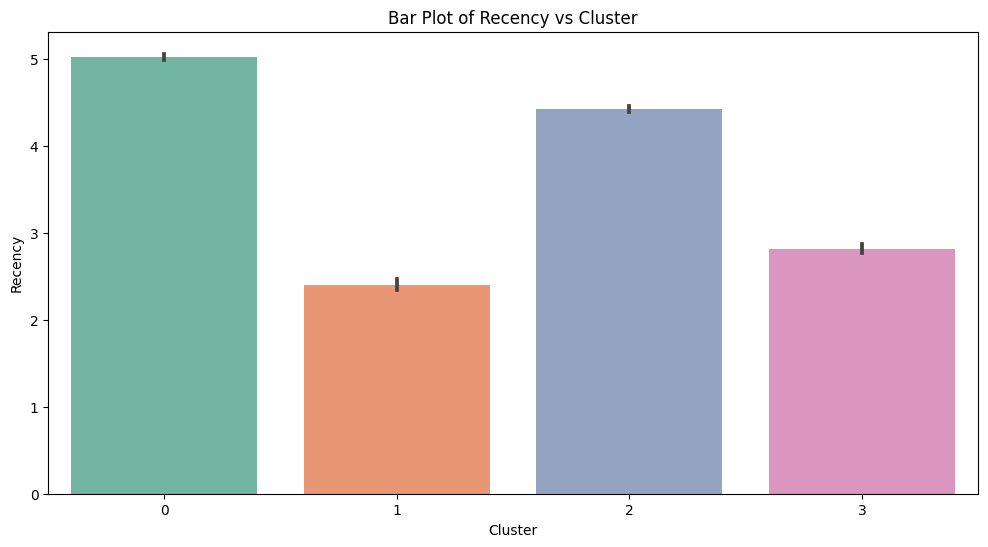

In [60]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster', y='Recency', data=rfm1, palette='Set2')
plt.title('Bar Plot of Recency vs Cluster')
plt.xlabel('Cluster')
plt.ylabel('Recency')
plt.show()

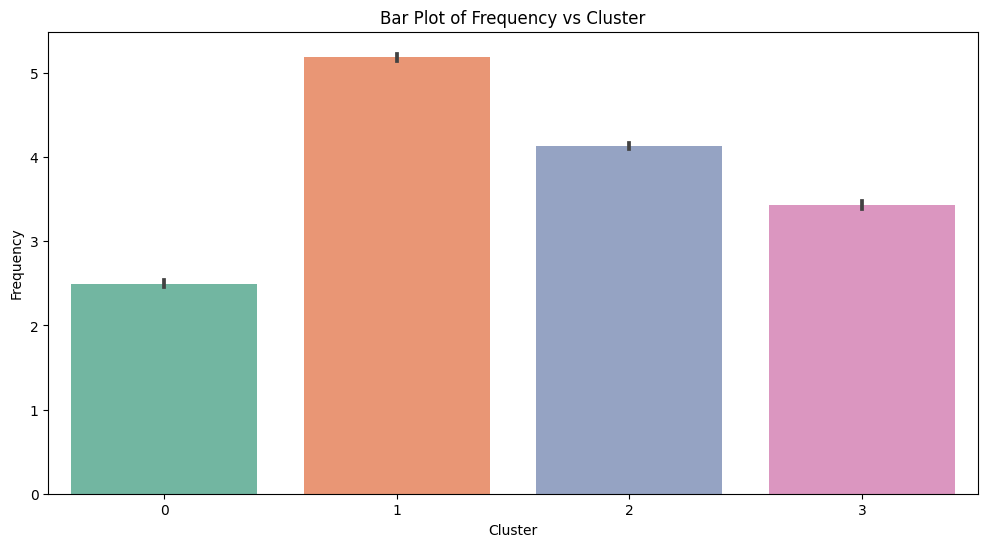

In [61]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster', y='Frequency', data=rfm1, palette='Set2')
plt.title('Bar Plot of Frequency vs Cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.show()

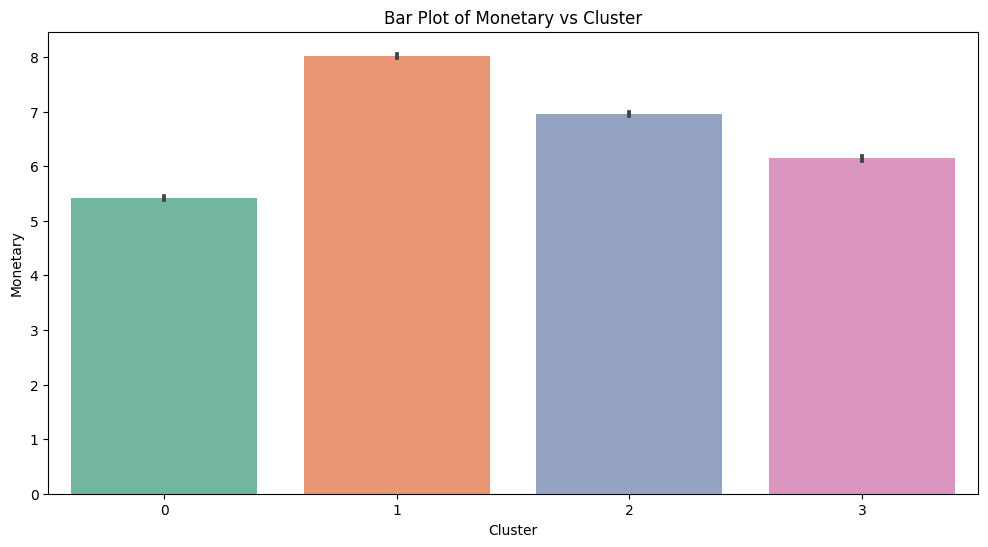

In [62]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster', y='Monetary', data=rfm1, palette='Set2')
plt.title('Bar Plot of Monetary vs Cluster')
plt.xlabel('Cluster')
plt.ylabel('Monetary')
plt.show()

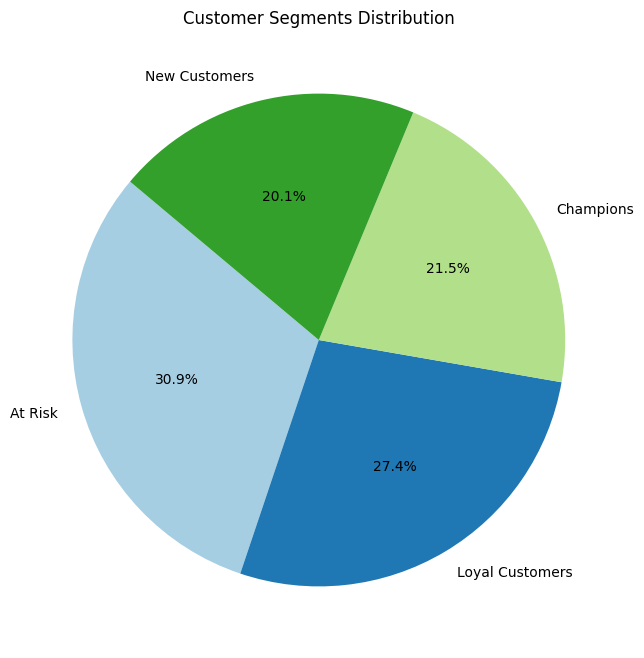

In [63]:
segment_counts = rfm1['Cluster Labels'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Customer Segments Distribution')
plt.show()

### Customer Segmentation: RFM Analysis and K-Means Clustering

The pie chart illustrates the customer segmentation results obtained by combining **RFM analysis** and **K-means clustering**. This approach categorizes customers into four distinct groups:

1. **Champions (21.5%)**  
   - **Characteristics**: Brand advocates with exceptional engagement and spending.  
   - **Behavior**: *Low Recency* (recent purchases), *High Frequency*, *High Monetary*.  
   - **Strategy**: Reward with loyalty programs and exclusives.

2. **Loyal Customers (27.4%)**  
   - **Characteristics**: Consistent buyers with moderate activity.  
   - **Behavior**: *Average Recency*, *High Frequency*, *High Monetary*.  
   - **Strategy**: Upsell/cross-sell opportunities to boost value.

3. **New Customers (20.1%)**  
   - **Characteristics**: Recent additions to the customer base.  
   - **Behavior**: *Low Recency* (very recent first purchase), *Low Frequency*, *Variable Monetary*.  
   - **Strategy**: Nurture with onboarding campaigns and welcome offers.

4. **At Risk (30.9%)**  
   - **Characteristics**: Declining engagement with potential churn risk.  
   - **Behavior**: *High Recency* (inactive for long), *Average Frequency*, *Low Monetary*.  
   - **Strategy**: Win-back campaigns or surveys to address dissatisfaction.

---

#### Key Insights:
- **Focus Priority**: Champions (21.5%) and Loyal Customers (27.4%) drive 48.9% of revenue.  
- **Critical Action**: 30.9% of customers are "At Risk" and require immediate retention efforts.  
- **Growth Opportunity**: New Customers (20.1%) offer potential for long-term loyalty if nurtured effectively.

**Next Steps**: Refine segmentation with dynamic clustering and align marketing strategies with segment behaviors.

## Predictions

In [64]:
def predictions(data):
 X_data = std_scaler.transform(data)
 pred = kmeans.predict(X_data)
 return pred

In [65]:
def customer_segmentation(Recency, Frequency, Monetary):
 print("Customer Segmentation")
 data_recency = np.log1p(Recency)
 data_frequency = np.log1p(Frequency)
 data_monetary = np.log1p(Monetary)
 data = pd.DataFrame({'Recency': [data_recency], 'Frequency': [data_frequency], 'Monetary': [data_monetary]})
 pred = predictions(data)
 print(f"The Customer belongs to {cluster_label[pred[0]]}")

In [66]:
customer_segmentation(5, 7, 100)

Customer Segmentation
The Customer belongs to New Customers


`i will take row from data to test the it's correct or not`

In [67]:
rfm1[rfm1['Cluster Labels']=='At Risk'].head()

,Recency,Frequency,Monetary,Cluster,Cluster Labels
3,5.739793,2.833213,5.688330,0,At Risk
5,5.323010,1.609438,4.499810,0,At Risk
7,5.370638,2.639057,6.132096,0,At Risk
13,5.662960,2.302585,5.169916,0,At Risk
17,5.676754,3.091042,5.773588,0,At Risk


In [68]:
customer_segmentation(5.739793, 2.833213, 5.688330)

Customer Segmentation
The Customer belongs to At Risk


<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#20B2AA; overflow:hidden"><b>Conclusion</b></div>

### RFM Analysis:
The RFM analysis helped us categorize customers into **10 distinct groups** based on their recency, frequency, and monetary values. This segmentation approach is highly informative as it reflects customer behavior in a very granular way. It allowed us to identify **exceptional customers** who are highly engaged and spend more, while also highlighting segments of customers who are not very active or have low spending.

### KMeans Clustering:
Using KMeans clustering, we were able to group customers into **4 clusters** based on their similarities in recency, frequency, and monetary values. This segmentation approach is more **flexible** compared to RFM as it does not rely on predefined grading, allowing the groups to naturally emerge from the data. The clusters provided valuable insights into customer behavior and helped us further refine our understanding of customer categories.

### Key Insights:
- **Focus Priority**: **Champions** (21.5%) and **Loyal Customers** (27.4%) drive **48.9% of revenue**. These segments should be the primary focus for retention efforts, offering exclusive perks or loyalty rewards to ensure continued engagement.
  
- **Critical Action**: **30.9% of customers** are classified as "**At Risk**" and require **immediate retention efforts**. These customers show signs of low engagement, and we must take quick action to prevent them from churning.

- **Growth Opportunity**: **New Customers** (20.1%) offer **potential for long-term loyalty** if nurtured effectively. By providing incentives, personalized communication, and excellent customer service, these customers can be transformed into loyal advocates.

- **Next Steps**: Refine segmentation with **dynamic clustering** and align **marketing strategies** with segment behaviors. This will enable us to better understand shifts in customer behavior over time and adapt our strategies accordingly.

In conclusion, by combining both RFM and KMeans segmentations, we can tailor our marketing strategies more effectively, focusing on retaining high-value customers while re-engaging or converting inactive ones.


**Thank you for taking the time to read through this notebook. I appreciate your attention and hope the insights shared here are useful for your projects.**

**Feel free to leave any feedback or suggestions**